# COMP 6321 Assignment 1

In this assignment you'll be clustering and classifying emojis!

<div style="margin-top:10px">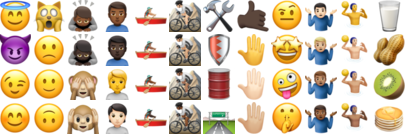</div>

The assignment is very much like a lab. It is broken into many small and specific steps that build on each other. The main differences are:
1. the assignment combines multiple concepts together,
3. the assignment will be carefully graded, and
2. where <span style="color:#080;font-weight:bold">specified</span>, you must add comments to your code.

There are 5 questions: Q1 (20 marks), Q2 (20 marks), Q3 (20 marks), Q4 (10 marks), Q5 (10 marks) and one bonus question Q6 (10 marks).

**Rules for academic integrity**:
* Like labs, students are encouraged to ask conceptual questions of TAs and of other students, and can answer each others' conceptual questions.
* Unlike labs, students are not allowed to post example code in a public forum, even if the code is wrong; code and pseudocode can only be shared with TAs when requesting help.
* Never ask for, or offer, code snippets for the assignment to your fellow students. Doing so is forbidden, and is a major violation of academic integrity, both of the person who shared the code and the person who accepted the code. Violations of academic integrity will be reported to the Dean's Office. Violators risk their academic standing.

**Advice:**
* *Invest in plotting.* Plotting is super important for ML and for data sciences generally. So, put in the time to learn how to make good plots, efficiently!
* *Always set random seeds.* Some steps of the assignment involve randomness, even if you do not explicitly ask for it. In order to make your assignment reproducible, you must set scikit-learn's *random_state* to a constant (e.g., to 0) whenever applicable.
* *Save your notebook frequently.* Although Jupyter notebooks are mostly reliable, it is possible to encounter an erroneous state, where the most recent changes cannot be saved to disk by the notebook's own save functionality.

**Run the code cell below** to import the necessary packages.

In [1]:
# import required packages 

import os                        # for os.path.exists
import json                      # for loading metadata
import urllib                    # for downloading remote files 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
import pickle
import scipy
from scipy.stats import uniform
import warnings                   # for turning off the warnings during the training process 
import sklearn.exceptions
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings(action='ignore')
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


from IPython.core.display import HTML    # for plotting the images in the middle of the cell 
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Matplotlib might complain that a lot of figures are open, but suppress that warning.
plt.rcParams.update({'figure.max_open_warning': 0})

**Run the code cell below** to define some utility functions for fetching data and for processing images.

In [2]:
def download(remoteurl: str, localfile: str):
    """
    Download remoteurl to localfile, unless localfile already exists.
    Returns the localfile string.
    """
    if not os.path.exists(localfile):
        print("Downloading %s..." % localfile)
        filename, headers = urllib.request.urlretrieve(remoteurl, localfile)
    return localfile

def rgba_to_rgb(image):
    """
    Converts image from RGBA format (H,W,4) to RGB format (H,W,3).
    Returns the new RGB image.
    """
    assert image.ndim == 3, "Expected 3-dimensional array"
    assert image.shape[2] == 4, "Expected 4 colour channels"
    assert image.max() <= 1, "Expected color values in range [0,1]"
    rgb, a = np.split(image, [3], axis=2)  # Split into (H,W,3) and (H,W,1)
    return a*rgb + (1-a)                   # Apply alpha blending to get RGB

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q1 &mdash; Download emoji metadata and images [20 marks total]

The image data and corresponding metadata that you need for this assignment is available from [github.com/imcal/emoji-data](https://github.com/iamcal/emoji-data), where you can also find a description of the data. The specific files you'll need are only:
* *emoji.json*
* *sheets-clean/sheet_{vendor}_{size}_clean.png*

where *{vendor}* is one of *{apple, facebook, google, twitter}* and *{size}* is the pixel resolution. You'll need emojis from all four vendors, but only the small *16x16* pixel versions (to make training faster). However, do NOT download the files manually.

<div style="border-bottom: 1px solid black;"></div>

### *Q1a &mdash;  Write code to download the files [5 marks]*

Use the *download* function defined above to fetch the five files *procedurally*. 

*Hint:* When you visit a Github URL in your browser, Github normally returns an HTML file for rendering in your web browser. To ask Github for an actual raw file (instead of the web page for displaying that file) you must use special URLs. If you view a file in your web browser https://github.com/iamcal/emoji-data/{path_to_file} then you should use URL https://github.com/iamcal/emoji-data/raw/master/{path_to_file}.

In [3]:
# download metadata and sheet-clean files from the GitHub url
emoji_size = 16    # define the considered emoji size
vendor = ['apple', 'facebook', 'google' , 'twitter']    # define various vendors names: apple, facebook, google and twitter

# download each emoji image of various vendors with size=16 from the aforementioned github address
for name in vendor:
    sheets_clean_apple = download('https://github.com/iamcal/emoji-data/raw/master/sheets-clean/sheet_' + name +
                              '_' + str(emoji_size)+'_clean.png' , 'sheet_'+ name + '_' + str(emoji_size) + '_clean.png')
    
# download meta data file (.json file) from the aforementioned github address
download('https://github.com/iamcal/emoji-data/raw/master/emoji.json', 'emoji.json')

'emoji.json'

<div style="border-bottom: 1px solid black;"></div>

### *Q1b &mdash;  Load and inspect the emoji metadata [5 marks]*

The emoji metadata is contained in a JSON file, which Python's **[json](https://docs.python.org/3/library/json.html)** module can easily load and parse for you.

**Write code** to load the *emoji.json* file, then display the metadata for the first emoji (index 0) so that you can see an example. It should have short name '*hash*'.

In [4]:
f = open('emoji.json') # Opening .json file
data = json.load(f)    # load .json file and put it a new variable named data
print('meta data file is belongs to ', type(data))      # show the data variable type
print('===============================================')
print('total size of the meta data files is:',len(data))   # show total size of metadata file (i.e., total number of emojies)
print('===============================================')
print(data[0]['short_name'])    # print the short_name category of the first emoji (i.e., emoji with index=0)

meta data file is belongs to  <class 'list'>
total size of the meta data files is: 1817
hash


**Write code** to find the index of the emoji having short name *'laughing'*, then display its metadata (the *dict* object). Do not use the *sort_order* field of the emoji metadata, it is not relevant to this assignment.

In [5]:
# metadata is a list which contains dictionaries 
# by iterating on each index of emojies in the meta data file, we try to find the emoji with short_name == laughing

for i in range(len(data)):
    if data[i]['short_name'] == 'laughing':
        print('index of emoji with laughing short_name is:', i)
        print('===============================================')
        print(data[i])

index of emoji with laughing short_name is: 1068
{'name': 'SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES', 'unified': '1F606', 'non_qualified': None, 'docomo': 'E72A', 'au': 'EAC5', 'softbank': None, 'google': 'FE332', 'image': '1f606.png', 'sheet_x': 32, 'sheet_y': 58, 'short_name': 'laughing', 'short_names': ['laughing', 'satisfied'], 'text': None, 'texts': [':>', ':->'], 'category': 'Smileys & Emotion', 'subcategory': 'face-smiling', 'sort_order': 5, 'added_in': '0.6', 'has_img_apple': True, 'has_img_google': True, 'has_img_twitter': True, 'has_img_facebook': True}


<div style="border-bottom: 1px solid black;"></div>

### *Q1c &mdash;  Load and inspect the emoji image data [10 marks]*

The emoji image data is contained in PNG files, which Matplotlib's **[imread](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imread.html)** function can load as a Numpy array. The image format is RGBA (*red*, *green*, *blue*, *alpha*) where *alpha* determines the opacity of each pixel.

**Write code** to load the four emoji sheet images. The list of images should be in order *{apple,facebook,google,twitter}*.

In [6]:
# load and save each vendors images as a numpy array and define each of them as a global variable based on each vendor's name
for name in vendor:
    globals()['emoji_' + name] = plt.imread('sheet_'+ name + '_' + str(emoji_size) + '_clean.png')

**Write code** to plot each vendor's sheet image. Generate four separate plots, where the title of each plot should be "*vendor* (*height*, *width*, *channels*)" where *height* and *width* are the size of the sheet and *channels* is the number of colour channels. Use the *figsize* argument of Matplotlib's *figure* function to enlarge the figures. The top of your first plot should look like this:

<div>
    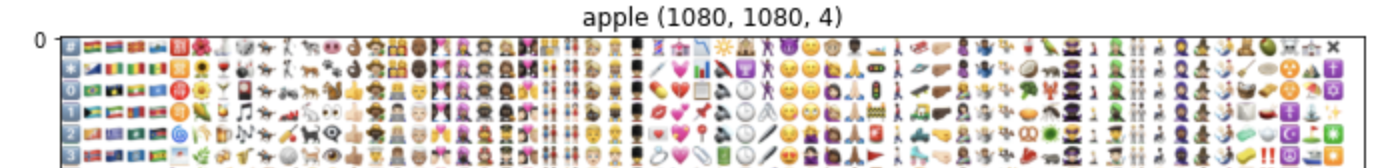
</div>


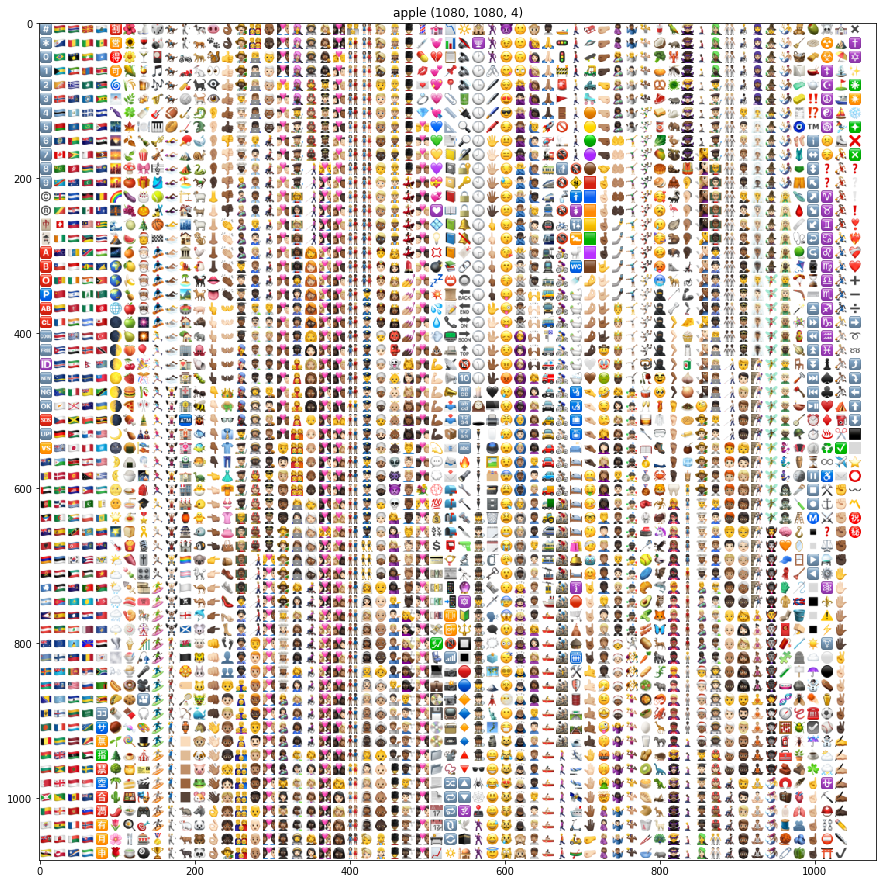

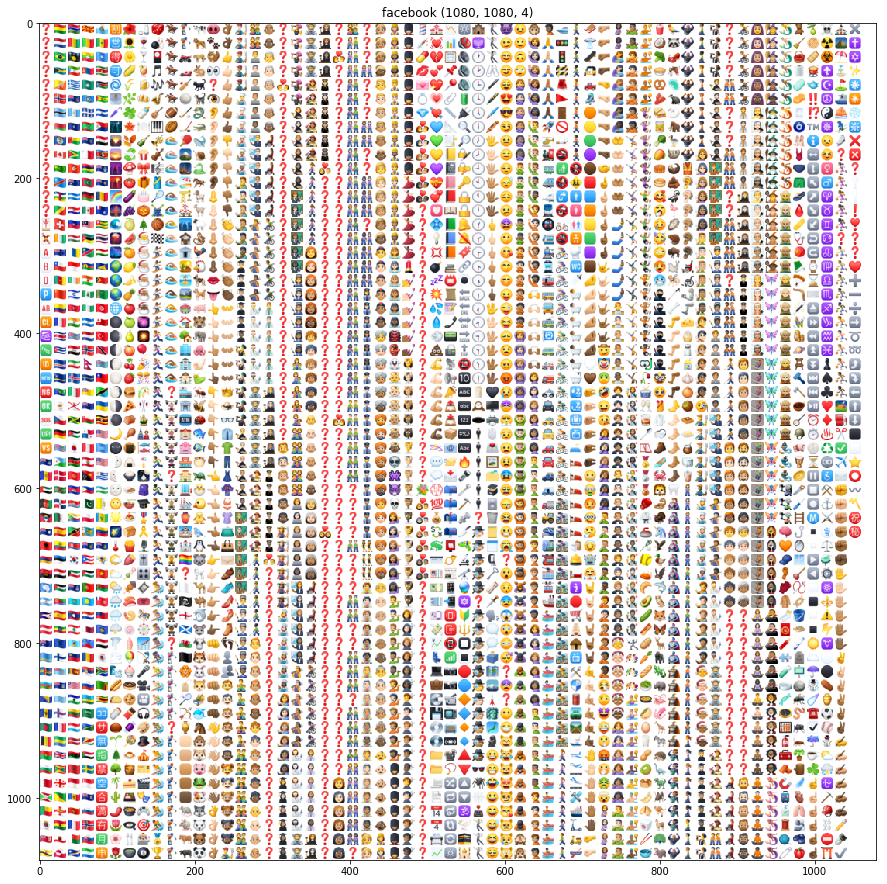

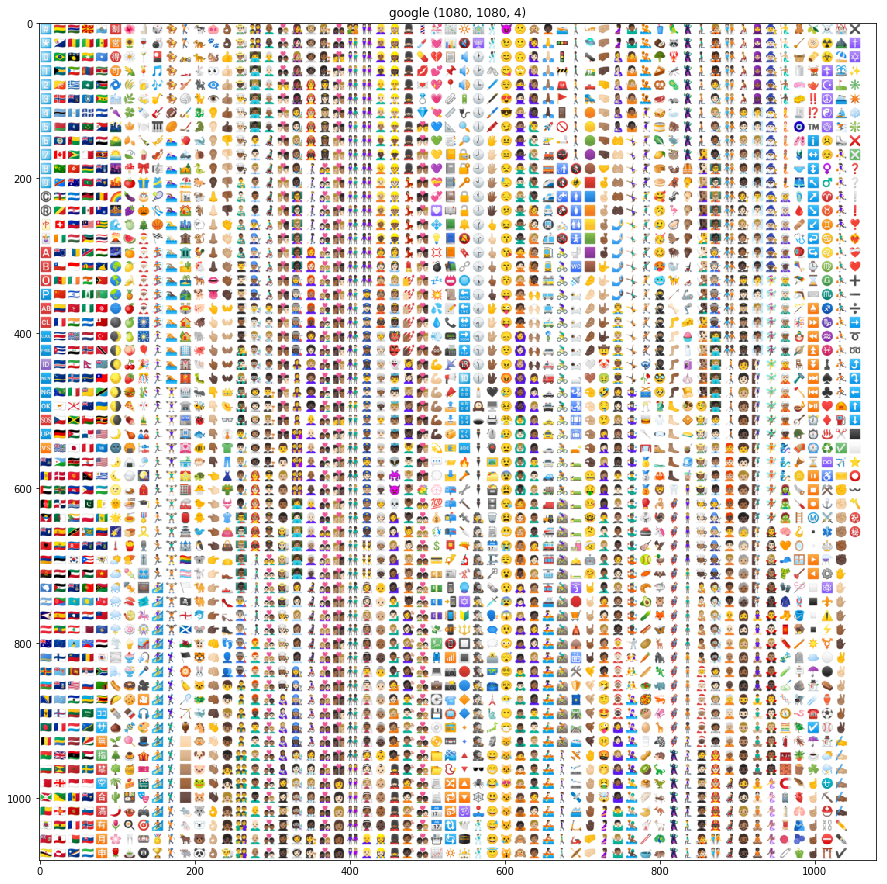

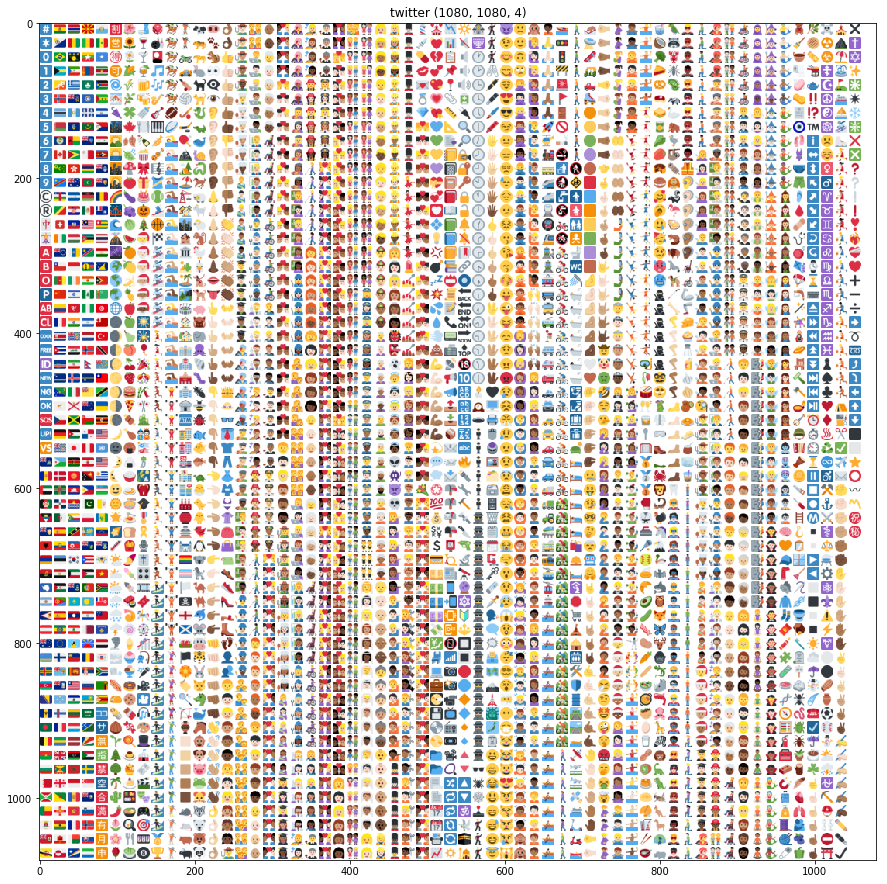

In [7]:
# plot each vendor image 

i = 0    # index of each vendor where vendor = ['apple', 'facebook', 'google' , 'twitter']
sheet_images = [emoji_apple, emoji_facebook, emoji_google, emoji_twitter]
for var_name in sheet_images:
    plt.figure(figsize=(15, 20))   # define size of figure
    plt.imshow(var_name)           # plot images
    plt.title(vendor[i] + ' ' + str(var_name.shape))   # set titles of each images based on vendors name and shape
    plt.show()
    i += 1             # increase the index of vendor variable to plot other images

**Write code** to generate the same four plots as above, except use Numpy slicing to display only the first 3 rows and 8 columns of the sheet. To ensure you do not crop any emojis, take note of any "padding" between the 16x16 emojis in the sheet. Your first plot should look like this, but with the shape numbers (?) and axis ticks filled in:

<div style="margin-top:10px">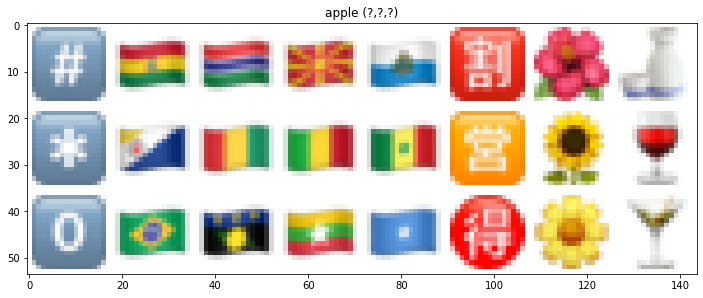</div>

(If you see a red question mark like <span style="color:red">?</span> for a vendor, it means they do not provide that particular emoji.)

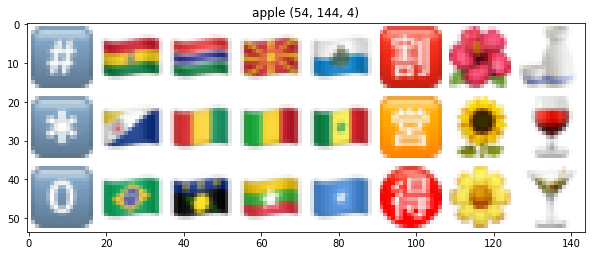

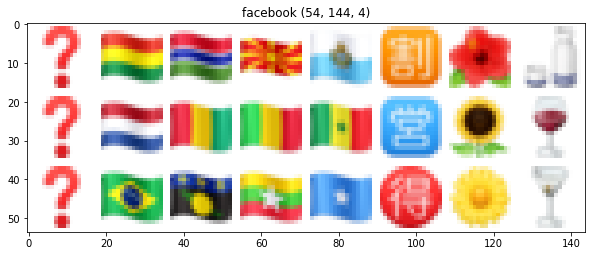

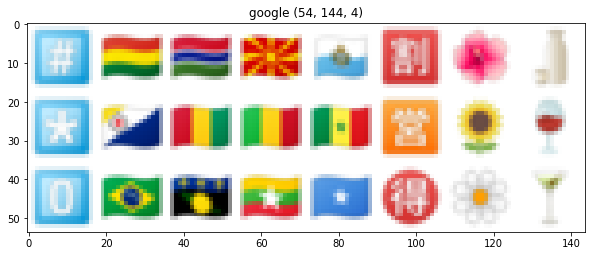

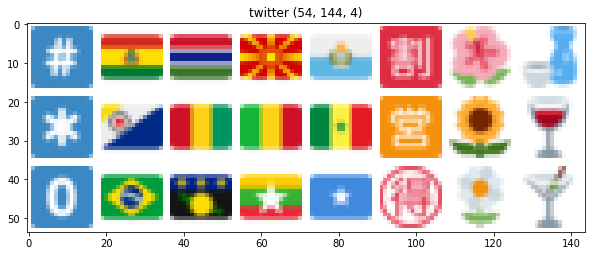

In [8]:
# plot an specific part of each images using the slicing method of numpy arrays 
# based on the README file in the github address the true size of each emoji should be considered as 18 pixels due distances ...
# between each emoji
i = 0    # index of each vendor where vendor = ['apple', 'facebook', 'google' , 'twitter']
size = 18                                  # define the size of each emoji (as pixels) NOTE: contain padding (actual size + 2)
num_x = 3                                  # define the number of emojies on x-axis that we want to show
num_y = 8                                  # define the number of emojies on y-axis that we want to show
for var_name in sheet_images:              # sheet images is a list variable which contains each image as a numpy array
    plt.figure(figsize=(10, 18))           # define size of each image for plotting
    sliced_var = var_name[0:num_x*size, 0:num_y*size]  # define the slicing on the numpy array
    plt.imshow(sliced_var)                             # show the sliced numpy array
    plt.title(vendor[i] + ' ' + str(sliced_var.shape)) # define the title of each image based on vendors name and sliced image shape
    plt.show()
    i += 1

**Implement *get_emoji_image*.** It should extract a 16x16 RGBA emoji image by its style index (0=*apple*, 1=*facebook*, 2=*google*, 3=*twitter*) and emoji index (as they appear in *emoji.json*). Internally, your function may refer to any global variables you have already defined (metadata, images, size, padding). Use the *sheet_x* and *sheet_y* fields of the metadata. Use slicing and avoid for-loops. <span style="color:#080;font-weight:bold">Briefly comment each line of your code.</span>

In [9]:
def get_emoji_image(style_index, emoji_index):
    """
    Given a vendor style index (apple=0,facebook=1,google=2,twitter=3)
    and an emoji index, returns the 16x16 RGBA image as a Numpy array
    with shape (16,16,4).
    """
    # 1: identify the vendor based on style_index 0: apple  1: facebook  2: google  3: twitter ...
    #    call the emoji image (numpy array) and save it in the emoji_img variable
    #    save the name of vendor in an string variable name 
    if style_index == 0:
        emoji_img = emoji_apple
        name = 'apple'
    elif style_index == 1:
        emoji_img = emoji_facebook
        name = 'facebook'
    elif style_index == 2:
        emoji_img = emoji_google
        name = 'google'
    else:
        emoji_img = emoji_twitter
        name = 'twitter'
    
    # 2: identify the emoji name based on emoji index and short_name category (from the meta data file)
    emoji_name = data[emoji_index]['short_name']
    sheet_size = 16                           # define the size of sheet
    sheet_x = data[emoji_index]['sheet_x']    # coordination of the emoji: x-axis
    sheet_y = data[emoji_index]['sheet_y']    # coordination of the emoji: y-axis
    
    # 3: define padding and coordination for slicing
    x = (sheet_x * (sheet_size + 2)) + 1;     # define padding in x for x-axis (based on README file from github address)
    y = (sheet_y * (sheet_size + 2)) + 1;     # define padding in y for y-axis (based on README file from github address)
    
    # 4: applying slicing on the emoji numpy array and convert it from 4 dim to 3 dim 
    return rgba_to_rgb(emoji_img[y:y+16, x:x+16])   

**Implement *plot_emoji_styles*.** Implement the *plot_emoji_styles* function below, using your *get_emoji_image* function as a subroutine. Use *figsize* to control the size of your figure, use Matplotlib's *subplot* and *title* functions along with its **[suptitle](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.suptitle.html)** to create titles that show the emoji index, the emoji short name, and the vendor title above each style, as shown below:

<div style="margin-top:10px">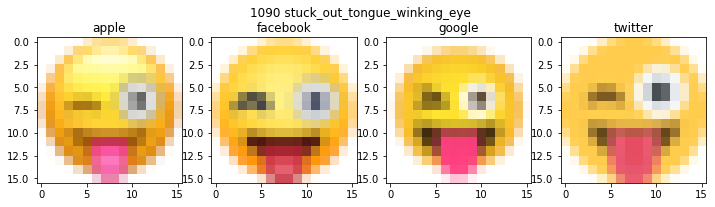</div>

In [10]:
def plot_emoji_styles(emoji_index): 
    """Plots all four vendor styles of the given emoji."""
    plt.figure(figsize=(10,7))
    # get the numpy array of the emoji for each of the vendors in a for loop 
    for i in range(4):
        plt.subplot(1, 4, i+1)
        emoji_name = data[emoji_index]['short_name']     # get emoji name based on the index of vendor = ['apple', 'facebook', 'google' , 'twitter'] 
        img = get_emoji_image(i, emoji_index)            # get the emoji numpy array using get_emoji_image function
        vendor_name = vendor[i]                          # get vendor name from the vendor (list)
        plt.title(vendor_name,size=10)                   # define title of each emoji image
        plt.imshow(img)                                  # plot emoji image
    plt.suptitle(str(emoji_index)+ ' ' + emoji_name,size=11, y=0.7)    # define subtitle of each emoji image

**Run your *plot_emoji_styles*** function to plot the '*laughing*' emoji from **Q1b**. Also plot two other emojis of your choosing. (Except poop. You're not allowed to plot the poop emoji. Don't you dare. No, no wait stop, have some self-respect, don't do it, noooo!)

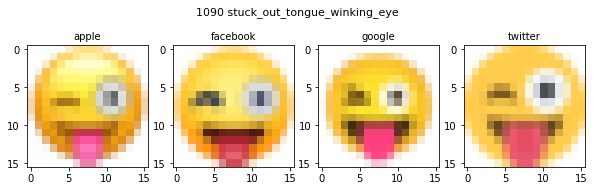

In [11]:
# plot emoji with index 1090 and short_name = stuck_out_tongue_eye for each vendor using plot_emoji_styles function
plot_emoji_styles(1090)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q2 &mdash; Build an emoji dataset for machine learning [20 marks total]

This question is about converting your list of four raw image sheets into a dataset $(\boldsymbol{X},\boldsymbol{y})$ suitable for training with scikit-learn. 

<div style="border-bottom: 1px solid black;"></div>

### *Q2a &mdash;  Build a set of inputs $\boldsymbol{X}$ from the sheet images [5 marks]*

**Write code** to build a Numpy array of inputs $\boldsymbol{X}$ having dtype *float32* and shape $(N,D)$ where $N$ is the total number of emoji images (number of emojis $\times$ number of vendors) and $D$ is the total number of pixels per emoji (height $\times$ width $\times$ channels). Each image should be converted from RGBA (4 channels) to RGB (3 channels) using the *rgba_to_rgb* function defined at the top of this lab. The first rows of $\boldsymbol{X}$ should all be apple emojis, followed by all facebook emojis, then all google emojis, and finally the last rows should be all twitter emojis. <span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [12]:
# build the dataset

height = 16   # height of image
width = 16    # width of image
channels = 3  # number of channels
X = np.zeros((1, height*width*channels), dtype=np.float32) # define a zero numpy array with dtype float32 and with height×width×channels columns
style_index = np.arange(len(vendor))                       # define style_index 0: apple  1: facebook  2: google  3: twitter

# get emjoies of each vendor and stack them to X(zero array) using vstack function
for i in style_index:                                        
    for j in range(len(data)):
        X = np.vstack((X, get_emoji_image(i, j).reshape(-1, 768)))
        
# remove the first row of X (row zero)
X = X[1:,:]

# print shape of X
print('shape of X is:', X.shape)

shape of X is: (7268, 768)


**Plot a row of your $\boldsymbol{X}$.** Demonstrate to the TA that the rows of your $\boldsymbol{X}$ matrix is an emoji image. Do so by accessing a single row of $\boldsymbol{X}$ and plotting it as a $16 \times 16$ RGB image.

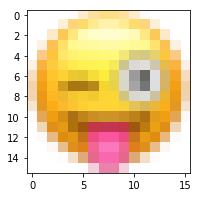

In [13]:
# plot emoji with index=1090 using defined X-array
plt.figure(figsize=(3,3))
plt.imshow(X[1090,:].reshape(16, 16, 3));   # reshape the sample with 768 columns to shape (16, 16, 3) and plot the emoji

<div style="border-bottom: 1px solid black;"></div>

### *Q2b &mdash;  Build a set of targets $\boldsymbol{y}$ from the metadata [5 marks]*

Here you'll enumerate the distinct emoji categories, and then build a vector of integer targets $\boldsymbol{y}$.

**Write code** to get a list of distinct emoji categories, using the *category* field from the metadata. For the TA, ensure that your list of categories is also displayed when the code cell below is executed.

In [14]:
# find all unique catagories in the meta data file

emojis_categories = []                             # define an empty list to append unique categories in it
for i in range(len(data)):
    emojis_categories += [data[i]['category']]     # read the category of all emojies and save it in the list
emojis_categories = list(set(emojis_categories))   # apply set function to get unique emojies categories and save unique categories in a list

# show the categories and its indexes
for i, name in enumerate(emojis_categories):
    print(i, name)

0 Symbols
1 Flags
2 Travel & Places
3 Activities
4 Objects
5 People & Body
6 Animals & Nature
7 Smileys & Emotion
8 Food & Drink
9 Component


**Write code** to build a Numpy array of inputs $\boldsymbol{y}$ having dtype *int32* and where $y_i \in \{0, \ldots, M-1\}$ with $M$ being the number of distinct emoji categories. The order of items in $\boldsymbol{y}$ should match those of $\boldsymbol{X}$ from **Q2a**. You may use any approach you like, but potentially useful functions include the *list* object's **[index](https://docs.python.org/3/tutorial/datastructures.html)** function and Numpy's **[np.tile](https://numpy.org/doc/stable/reference/generated/numpy.tile.html)** function. <span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [15]:
# define y for the dataset
labels = []    # define an empty list to save the index of categories for each emoji as a label
for emoji in data:                                          # read each emoji from meta data file by iterating on the file
    for category in emojis_categories:                      # read each emoji categories from the list of unique categories
        if (emoji['category'] == category):
            labels.append(emojis_categories.index(category))  # read the index of category and append it the empty list (label)

# apply tile function on achieved labels to extend it for all 4 vendors
y = np.tile(np.array(labels), 4)    

# print the shape of y as labels (targets)
print('shape of y is:', y.shape)

shape of y is: (7268,)


**Write code** to demonstrate that, for each training example $i$ corresponding to a '*laughing*' emoji (for apple, facebook, google, twitter), its $y_i$ label is set to be the index of the "Smileys & Emotion" category.

In [16]:
print('Smileys & Emotion label:', emojis_categories.index("Smileys & Emotion"))
print('=============================')
# we have found the index of emoji with short_name of laughing as 1068
for i, j in enumerate([1068, 1068 + len(data), 1068 + 2*len(data), 1068 + 3*len(data)]):
    print('label of laughing emoji in '+ vendor[i] + ' is:', y[j])

Smileys & Emotion label: 7
label of laughing emoji in apple is: 7
label of laughing emoji in facebook is: 7
label of laughing emoji in google is: 7
label of laughing emoji in twitter is: 7


<div style="border-bottom: 1px solid black;"></div>

### *Q2c &mdash;  Split and preprocess the data [10 marks]*

**Write code** to randomly split $(\boldsymbol{X}, \boldsymbol{y})$ into three parts, with no overlap:
1. a *training* set $(\boldsymbol{X}_\text{trn}, \boldsymbol{y}_\text{trn})$, which you will use to directly train classifiers
2. a *validation* set $(\boldsymbol{X}_\text{val}, \boldsymbol{y}_\text{val})$, which you will use to estimate the best value for a hyperparameter
3. a *test* set $(\boldsymbol{X}_\text{tst}, \boldsymbol{y}_\text{tst})$, which you will use to evaluate final performance of the 'best' hyperparameters

The training data should comprise 60% of the full data set. The validation and testing data should each comprise 20% of the original data. Use the **[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)** function and remember to set *random_state* so that your splits (and thereby your conclusions) are reproducible for TAs.

In [17]:
# 1: separate test data
X_t, X_tst, y_t, y_tst = train_test_split(X, y, test_size=0.2, random_state=0)

# 2: separate train data and validation data
X_trn, X_val, y_trn, y_val = train_test_split(X_t, y_t, test_size=0.2, random_state=0)

**Write code** to normalize the features of $\boldsymbol{X}_\text{trn}$, $\boldsymbol{X}_\text{val}$, and $\boldsymbol{X}_\text{tst}$, using scikit-learn's **[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)**. Be careful which subset of the data you use for estimating the *StandardScaler* object's *scale_* and *mean_* attributes.

In [18]:
# 1: define the scaler and fit it to training data
scaler = StandardScaler().fit(X_trn)

# 2: transform training, testing and validation data using the trained scaler
scaled_trn = scaler.transform(X_trn)
scaled_val = scaler.transform(X_val)
scaled_tst = scaler.transform(X_tst)

**Plot a scaled and unscaled emoji side-by-side.** Choose a row from $\boldsymbol{X}_\text{trn}$ and show how it appears as an RGB image with and without scaling. If Matplotlib complains that "values are not in range [0,1]," consider using **[np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)**. Your plot should look similar to the example below, although the choice of emoji could differ.

<div style="margin-top:10px">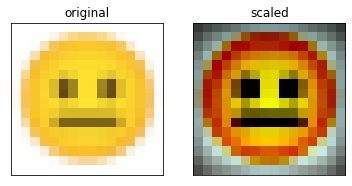</div>

*Hint:* You do not need to know which row in $\boldsymbol{X}_\text{trn}$ corresponds to which row in $\boldsymbol{X}$. Instead you can "undo" the scaling on whatever row you pick, using one of the methods provided by *StandardScaler*.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


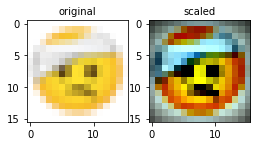

In [19]:
# plot a sample with index 951 from the training dataset (original data and scaled data)
plt.figure(figsize=(4,3))
plt.subplot(1,2,1)
plt.imshow(X_trn[951,:].reshape(16,16,3));     # plot original sample
plt.title('original',size=10);

plt.subplot(1,2,2)
plt.imshow(scaled_trn[951,:].reshape(16,16,3)); # plot scaled sample
plt.title('scaled',size=10);

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q3 &mdash; Train classifiers and identify good hyperparameters [20 marks total]

This question has several goals:
1. to help you visualize how hyperparameters affect training/validation/test performance.
2. to give you a sense for how long certain classifiers take to train or to make predictions.
3. to force you to try two useful Python language features: (a) passing types as arguments, and (b) argument forwarding.

(However, please take the hyperparameter search lab as a better example of how to use scikit-learn for hyperparameter search; this assignment is focused on making things easy to plot and visualize, not on automating the search itself.)

<div style="border-bottom: 1px solid black;"></div>

### *Q3a &mdash;  Write a utility function that trains multiple estimators [5 marks]*

Throughout **Q3**, you will be training multiple estimators, each with a different hyperparameter setting.

**Implement the *train_estimators* utility function.** The idea of this function is to make it easy to train multiple versions of an estimator where one hyperparameter (specified by *param_name*) gets to take on a different value (specified by *param_vals*) for each instance. See the docstring below. *Hint:* Look at scikit-learn's [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) class documentation.

In [20]:
def train_estimators(base_estimator, X, y, param_name, param_vals):
    """
    Trains multiple instances of `base_estimator` on (X, y) where for each instance
    the parameter named `param_name` is set to a value from `param_vals`.
    Prints a message before training each instance.
    Returns the list of trained estimators.
    
    For example:
    
       >>> train_estimators(DecisionTreeClassifier(splitter='random', random_state=0),
                            X, y, 'max_depth', [1, 5, 10])
    
       Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...

       [DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')] 
    """
    out = list()     # define an empty list to save the trained classifiers 
    # 1: train and save the classifiers
    for idx, vals in enumerate(param_vals):              
        base_estimator.set_params(**{param_name:vals})   # assigne the each param_val for the classfier's param_name  
        clf = base_estimator.fit(X, y)                   # train the classifier
        print(clf)                                       # print the results of the trained classifier
        filename = 'clf_' + str(idx + 1) + '.sav'        # set a name for the trained classifier 
        pickle.dump(clf, open(filename, 'wb'))           # save the trained classifier as a pickle file
        
        # load the trained classifiers
    for i in range(len(param_vals)):                      
        filename = 'clf_' + str(i + 1) + '.sav'          # call the name of saved classifier
        model = pickle.load(open(filename, 'rb'))        # load the trained classfier (the pickle file)
        out.append(model)                                # append the classifier to the empty list
        
        # return the trained classifiers  
    return out

**Run the code cell below** to test your implementation of *train_estimators*. (Replace *X_trn* and *y_trn* with whatever you called your training set variables.)

In [21]:
# check the train_estimators function
train_estimators(sklearn.tree.DecisionTreeClassifier(splitter='random', random_state=0),
                                   scaled_trn, y_trn, 'max_depth', [1, 5, 10])

DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')


[DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random'),
 DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random'),
 DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')]

<div style="border-bottom: 1px solid black;"></div>

### *Q3b &mdash;  Train multiples models, plot their accuracies, and identify good parameters [15 marks]*

**Implement the *score_estimators* utility function.** This will be handy for scoring a list of estimators on a particular data set, such as $(\boldsymbol{X}_\text{trn}, \boldsymbol{y}_\text{trn})$. Use the estimator's own *score* method.

In [22]:
def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # define an empty list to save scores
    scores = []
    for clf in estimators:
        scores += [float('%.3f' % clf.score(X, y))]    # computing the score of each classifier
        
    return np.array(scores)

**Run the code cell below** to test your implementation. It should print three scores per dataset. Each score is a measure of classification accuracy. (Replace *X_trn* and *y_trn* etc with your dataset variable names.)

In [23]:
tree_estimators = train_estimators(sklearn.tree.DecisionTreeClassifier(splitter='random', random_state=0),
                                   scaled_trn, y_trn, 'max_depth', [1, 5, 15])
print('=================================================================')
print("train:   ", score_estimators(scaled_trn, y_trn, tree_estimators))
print("validate:", score_estimators(scaled_val, y_val, tree_estimators))
print("test:    ", score_estimators(scaled_tst, y_tst, tree_estimators))

DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=15, random_state=0, splitter='random')
train:    [0.308 0.538 0.966]
validate: [0.292 0.508 0.518]
test:     [0.292 0.511 0.551]


You should see that the 3rd column (corresponding to *max_depth=15*) performs best, especially on training.

**Run the code cell below** to see a demonstration of the `%%time` feature of Jupyter (see [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time)). Note that `%%time` only works if it is the first line in a code cell, before any comments.

In [24]:
%%time
for i in range(1000000):  # Burn some CPU cycles in a
    pass                  # loop that does nothing

Wall time: 53.9 ms


**Train multiple *DecisionTreeClassifier*s** on the training set, such that *train_estimators* produces the following output:

    Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')...

In [25]:
%%time
np.random.seed(0)
# train decision tree classifiers with max_depth = [1, 5, 10, 20, 50, 100]
DT_estimators = train_estimators(sklearn.tree.DecisionTreeClassifier(splitter='random', random_state=0),
                                       scaled_trn, y_trn, 'max_depth', [1, 5, 10, 20, 50, 100])

DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')
DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')
Wall time: 2.97 s


**Implement *plot_estimator_scores*** to visualize the effect of the parameter on accuracy. When applied to the decision tree estimators you trained in the previous cell, the plot should look like below, including legend, colours, marks, and x-axis ticks, but your precise scores may differ depending on how you decided to split the data.

<div style="margin-top:10px">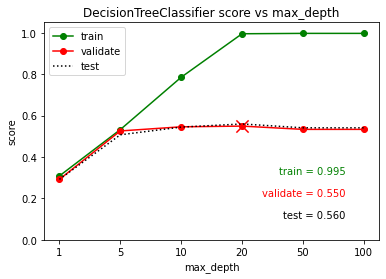</div>

*Hint:* You can use your *score_estimators* implementation, but do not do any training.

*Hint:* For the title, you can get the object's type from its `__class__` attribute, and you can get the name of its type from the type's `__name__` attribute. Use the first object in *estimators* to determine the name of the classifier type that you're plotting.

*Hint:* If your $x$-axis points are not evenly spaced, you can plot each series using any evenly-spaced $x$ values (e.g. via *np.arange*) and then override the $x$-axis tick labels with whatever you want. See the *labels* argument of Matplotlib's **[xticks](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xticks.html)** function.

In [26]:
def plot_estimator_scores(estimator, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # 1: computing the scores of trained estimators for each dataset
    trn_scores = score_estimators(scaled_trn, y_trn, estimator)
    val_scores = score_estimators(scaled_val, y_val, estimator)
    tst_scores = score_estimators(scaled_tst, y_tst, estimator)

    # 2: compute the max score for trained classifiers based on validation set
    best_index = max(enumerate(val_scores), key=lambda x: x[1])[0]
    best_score = max(val_scores)
    
    # 3: return the estimators name
    clf = estimator[0]
    clf_name = clf.__class__.__name__
    plt.figure(figsize=(6,4))

    # 4: plot the scores of each classifier on each dataset (train/test/validation)
    plt.plot(param_vals,trn_scores,color='green',linestyle='-', marker='o')
    plt.plot(param_vals,val_scores,color='red',linestyle='-', marker='o')
    plt.plot(param_vals,tst_scores,color='black',linestyle='--')
    
    # 5: plot the highest score of the classifier on validation set
    plt.scatter(param_vals[best_index],best_score,marker='x',color='red',s=150)
    
    # 6: set the figure properties  
    plt.xlabel(param_name)
    plt.ylabel('score')
    plt.title(clf_name + ' score vs '+ param_name)
    plt.legend(['train','validate','test'])
    
    print('best ' + clf_name + ' is ' + str(best_index+1))
    
    # settings for DecisionTreeClassifier plots
    if clf_name == 'DecisionTreeClassifier':
        plt.xticks([0, 20, 40, 60, 80, 100], [1, 5, 10, 20, 50, 100])
        plt.text(65,0.85,'train = '+ str(max(trn_scores)), color='green')
        plt.text(65,.8,'validate = '+ str(max(val_scores)), color='red')
        plt.text(65,.75,'test = '+ str(max(tst_scores)), color='black')
    
    # settings for RandomForestClassifier plots
    elif clf_name == 'RandomForestClassifier':
        plt.xticks([0, 20, 40, 60, 80, 100],[1, 5, 10, 20, 50, 100])
        plt.text(65,0.85,'train = '+ str(max(trn_scores)), color='green')
        plt.text(65,.8,'validate = '+ str(max(val_scores)), color='red')
        plt.text(65,.75,'test = '+ str(max(tst_scores)), color='black')
    
    # settings for LogisticRegression plots
    elif clf_name == 'LogisticRegression':
        plt.xticks([0, 0.2, .40, .60, .80, 1], [1e-05, 0.0001, 0.001, 0.01, 0.1, 1])
        plt.text(.6,0.7,'train = '+ str(max(trn_scores)), color='green')
        plt.text(.6,.65,'validate = '+ str(max(val_scores)), color='red')
        plt.text(.6,.6,'test = '+ str(max(tst_scores)), color='black')
    
    # settings for SVM classifier plots
    else:
        plt.xticks([0, 200, 400, 600, 800, 1000], [0.01, 0.1, 1, 10, 100, 1000])
        plt.text(700,0.85,'train = '+ str(max(trn_scores)), color='green')
        plt.text(700,.8,'validate = '+ str(max(val_scores)), color='red')
        plt.text(700,.75,'test = '+ str(max(tst_scores)), color='black')

**Plot the *DecisionTreeClassifier* scores** by calling your *plot_estimator_scores* function. Your plot should look like the example plot.

best DecisionTreeClassifier is 3
Wall time: 96.7 ms


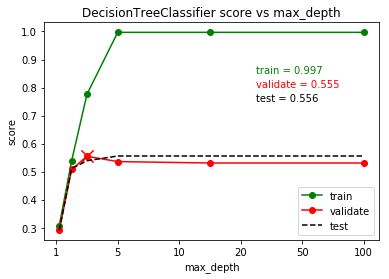

In [27]:
%%time
# plot the results of DecisionTreeClassifier
plot_estimator_scores(DT_estimators, 'max_depth', [1, 5, 10, 20, 50, 100])

**Train multiple *RandomForestClassifiers*** such that *train_estimators* produces the following output:

    Training RandomForestClassifier(max_depth=1, random_state=0)...
    Training RandomForestClassifier(max_depth=5, random_state=0)...
    Training RandomForestClassifier(max_depth=10, random_state=0)...
    Training RandomForestClassifier(max_depth=20, random_state=0)...
    Training RandomForestClassifier(max_depth=50, random_state=0)...
    Training RandomForestClassifier(max_depth=100, random_state=0)...

In [28]:
%%time
# train RandomForestClassifier with max_depth = [1, 5, 10, 20, 50, 100]
RFC_estimators = train_estimators(sklearn.ensemble.RandomForestClassifier(random_state=0),
                                   scaled_trn, y_trn, 'max_depth', [1, 5, 10, 20, 50, 100])

RandomForestClassifier(max_depth=1, random_state=0)
RandomForestClassifier(max_depth=5, random_state=0)
RandomForestClassifier(max_depth=10, random_state=0)
RandomForestClassifier(max_depth=20, random_state=0)
RandomForestClassifier(max_depth=50, random_state=0)
RandomForestClassifier(max_depth=100, random_state=0)
Wall time: 32.1 s


**Plot the *RandomForestClassifier* scores**, again by calling your *plot_estimator_scores* function.

best RandomForestClassifier is 5
Wall time: 1.56 s


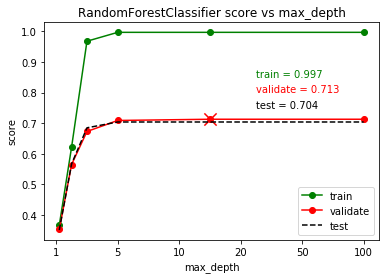

In [29]:
%%time
# plot the results of RandomForestClassifier
plot_estimator_scores(RFC_estimators, 'max_depth', [1, 5, 10, 20, 50, 100])
# Your code here. Aim for 1 line.

**Train multiple *LogisticRegression* classifiers** such that *train_estimators* produces the following output:

    Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
    Training LogisticRegression(max_iter=10000, random_state=0)...
    
The omission of *C* when the final estimator was printed means it was trained with its default value, which is *C*=1. For example:
```python
>>> LogisticRegression(C=1.01)
LogisticRegression(C=1.01)

>>> LogisticRegression(C=1.0)
LogisticRegression()
```

In [30]:
%%time
# train LogisticRegression classifiers with C = [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
LRC_estimators = train_estimators(sklearn.linear_model.LogisticRegression(max_iter=10000, random_state=0),
                                   scaled_trn, y_trn, 'C', [1e-05, 0.0001, 0.001, 0.01, 0.1, 1])

LogisticRegression(C=1e-05, max_iter=10000, random_state=0)
LogisticRegression(C=0.0001, max_iter=10000, random_state=0)
LogisticRegression(C=0.001, max_iter=10000, random_state=0)
LogisticRegression(C=0.01, max_iter=10000, random_state=0)
LogisticRegression(C=0.1, max_iter=10000, random_state=0)
LogisticRegression(C=1, max_iter=10000, random_state=0)
Wall time: 43 s


**Plot the *LogisticRegression* scores**, again by calling your *plot_estimator_scores* function.

best LogisticRegression is 4
Wall time: 329 ms


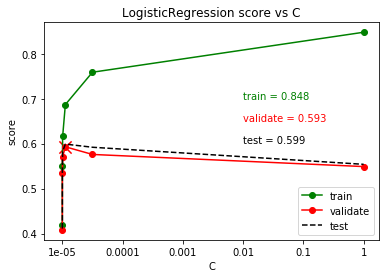

In [31]:
%%time
# plot the results of LogisticRegression classifiers
plot_estimator_scores(LRC_estimators, 'C', [1e-05, 0.0001, 0.001, 0.01, 0.1, 1])

**Train multiple SVM classifiers (*SVC*)** such that *train_estimators* produces the following output:

    Training SVC(C=0.01, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=0.1, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=10.0, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=100.0, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=1000.0, gamma=0.001, max_iter=10000, random_state=0)...

In [32]:
%%time
# train SVC classifiers with C = [0.01, 0.1, 1, 10, 100, 1000]
SVC_estimators = train_estimators(sklearn.svm.SVC(gamma=0.001,max_iter=10000, random_state=0),
                                   scaled_trn, y_trn, 'C', [0.01, 0.1, 1, 10, 100, 1000])

SVC(C=0.01, gamma=0.001, max_iter=10000, random_state=0)
SVC(C=0.1, gamma=0.001, max_iter=10000, random_state=0)
SVC(C=1, gamma=0.001, max_iter=10000, random_state=0)
SVC(C=10, gamma=0.001, max_iter=10000, random_state=0)
SVC(C=100, gamma=0.001, max_iter=10000, random_state=0)
SVC(C=1000, gamma=0.001, max_iter=10000, random_state=0)
Wall time: 1min 19s


**Plot the *SVM* scores**, again by calling your *plot_estimator_scores* function. Predictions may take several minutes to compute.

best SVC is 4
Wall time: 2min 23s


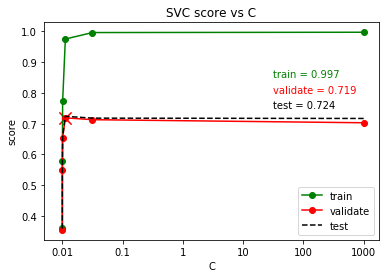

In [33]:
%%time
# plot the results of SVM classifiers
plot_estimator_scores(SVC_estimators, 'C', [0.01, 0.1, 1, 10, 100, 1000])

**Question.** Do your plots support the claim that "validation set performance" is a good estimate of "test set performance" overall? YES/NO then explain below.

**Question.** Which of your classifiers had the highest test-set performance for its "best" configuration (i.e., for the configuration with highest validation-set performance)? Name the classifier and best hyperparameter setting (*max_depth* or *C*).

**Question.** Which of your classifiers had the *least over-fitting*, if we measured overfitting as the absolute difference between training-set and testing-set performance? Name the classifier and hyperparameter setting (*max_depth* or *C*).

**Question.** Which if your classifiers was slowest to train? Name the classifier.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q4 &mdash; Visualizing mistakes [10 marks total]

The goal here is to visualize classification errors, by confusion matrix and by inspecting typical mistakes.

<div style="border-bottom: 1px solid black;"></div>

### *Q4a &mdash;  Plot a confusion matrix for the best estimators [5 marks]*

**Write code** to plot a confusion matrix for each of the 'best' estimators in **Q3** when applied to test set $(\boldsymbol{X}_\text{tst}, \boldsymbol{y}_\text{tst})$. Here, 'best' means best validation score. All estimators are already trained, so you can simply pull out the one best of each type {tree, forest, logistic, svm}. Use **[plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)** or **[ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)**. Your first plot should look like as below, though the numbers may differ.

<div style="margin-top:10px">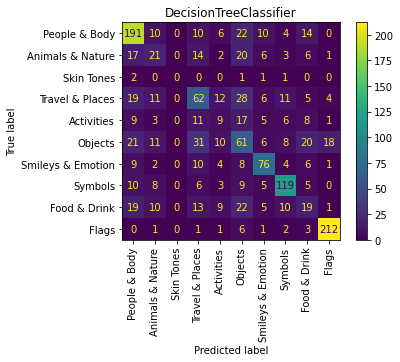</div>

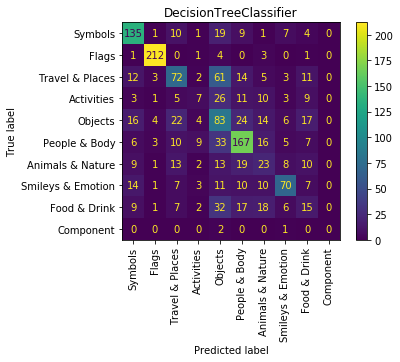

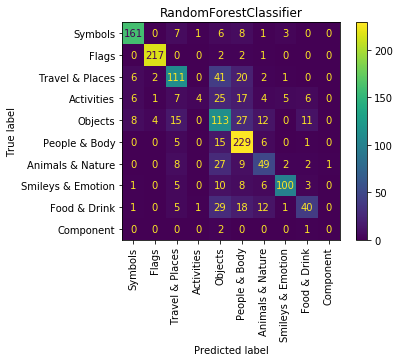

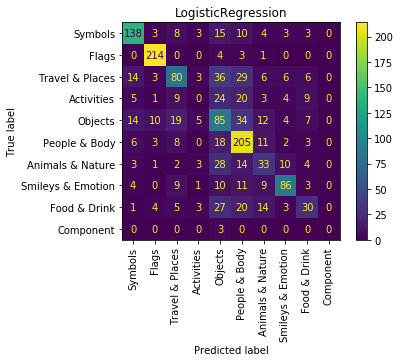

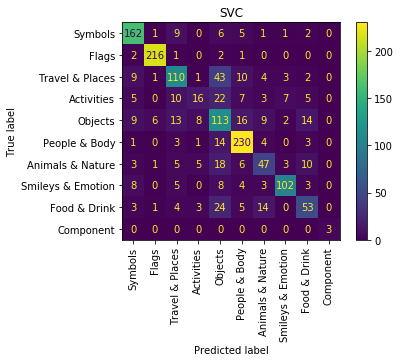

In [34]:
best_DT = DT_estimators[2]                           # best decision tree classifier
plot_confusion_matrix(best_DT, scaled_tst, y_tst)         # plot confusion matrix 
plt.title(DT_estimators[0].__class__.__name__)
plt.xticks(np.arange(10),emojis_categories,rotation='vertical');
plt.yticks(np.arange(10),emojis_categories,rotation='horizontal');

best_RFC = RFC_estimators[4]                         # best random forest classifier
plot_confusion_matrix(best_RFC, scaled_tst, y_tst)        # plot confusion matrix
plt.title(RFC_estimators[0].__class__.__name__)
plt.xticks(np.arange(10),emojis_categories,rotation='vertical');
plt.yticks(np.arange(10),emojis_categories,rotation='horizontal');

best_LRC = LRC_estimators[3]                        # best logestic regression classifier
plot_confusion_matrix(best_LRC, scaled_tst, y_tst)       # plot confusion matrix
plt.title(LRC_estimators[0].__class__.__name__)
plt.xticks(np.arange(10),emojis_categories,rotation='vertical');
plt.yticks(np.arange(10),emojis_categories,rotation='horizontal');

best_SVC = SVC_estimators[3]                        # best SVM classifier
plot_confusion_matrix(best_SVC, scaled_tst, y_tst)       # plot confusion matrix
plt.title(SVC_estimators[0].__class__.__name__);
plt.xticks(np.arange(10),emojis_categories,rotation='vertical');
plt.yticks(np.arange(10),emojis_categories,rotation='horizontal');

**Question.** What classifier is best at distinguishing between the *Flags* class and the *Objects* class, overall? Name the classifier and justify your choice.

<div style="border-bottom: 1px solid black;"></div>

### *Q4b &mdash;  Identify specific misclassified examples [5 marks]*

In this question, use the "best performing" classifier that you named at the end of **Q4a**.

**Write code** to identify all "*Objects* misclassified as *Flags*" from the test-set and then plot them as images. (The phrase "*A* misclassified as *B*" means the prediction was *B* but the true class was *A*.) Your code for identifying the misclassified examples should be vectorized, for example using functions like *np.logical_and* and/or *np.nonzero*. (Remember you might need to "undo" the feature normalization like in **Q2c**).

Objects misclassified as Flags


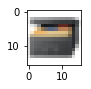

Objects misclassified as Flags


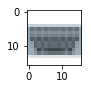

Objects misclassified as Flags


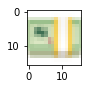

Objects misclassified as Flags


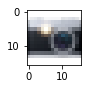

In [35]:
# Note: based on the previous section, 4 Objects classified as Flags wrongly

y_pred = best_RFC.predict(scaled_tst)      # compute the predictions of best SVM classifier for test data

obj = emojis_categories.index("Objects")   # compute the label of objects class
flag = emojis_categories.index("Flags")    # compute the label of flag class
for idx in range(y_tst.shape[0]):          
    if y_tst[idx] == obj:                  # separating all of the with label objects from the dataset
        if y_pred[idx] == flag:            # separating wrong predictions (object missclassified as flag) 
            print(str(emojis_categories[y_tst[idx]]) + ' misclassified as '+ str(emojis_categories[y_pred[idx]]))
            plt.figure(figsize=(1,1))
            plt.imshow(scaler.inverse_transform(scaled_tst[idx,:]).reshape(16, 16, 3))
            plt.show()

**Question.** After seeing the failure cases above, can you guess why the estimator is confusing them with *Flags*? Explain in 1-2 sentences.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q5 &mdash; Visualizing feature importances [10 marks total]

The goal here is to visualize sensitivity to specific input features.

<div style="border-bottom: 1px solid black;"></div>

### *Q5a &mdash;  Visualize the feature importances of a RandomForestClassifier [5 marks]*

**Implement *plot_random_forest_importances*** below. This function should plot the *feature_importances_* attribute of a *RandomForestClassifier* (see scikit-learn docs). For the random forests you trained, there are $16 \times 16 \times 3$ features, so to make visualization easy the feature importances should be organized into three separate side-by-side heatmaps: one for each RGB colour channel. When plotting a heatmap, use *cmap*='cool' to choose the colour map. For example, plotting the feature importances of a random forest with *max_depth*=1 should look something like this:

<div style="margin-top:10px">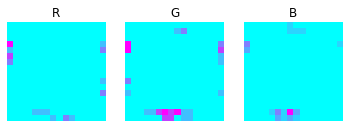</div>

In [36]:
def plot_random_forest_importances(estimator):
    """
    Plots the feature importances of the given RandomForestClassifier,
    arranged as three separate 16x16 heatmaps for (red, green, blue).
    """
    # compute the feature_importances array of the random forest classifier and reshape it to 16×16×3 for visualization    
    # plotting the feature_importances for R G B separately
    plt.figure(figsize=(7,5))
    plt.subplot(1,3,1)
    plt.imshow(estimator.feature_importances_.reshape(16, 16, 3)[:,:,0],cmap='cool')    # for R
    plt.title('R')

    plt.subplot(1,3,2)
    plt.imshow(estimator.feature_importances_.reshape(16, 16, 3)[:,:,1],cmap='cool')    # for G
    plt.title('G')

    plt.subplot(1,3,3)
    plt.imshow(estimator.feature_importances_.reshape(16, 16, 3)[:,:,2],cmap='cool')    # for B
    plt.title('B')

    plt.show()

**Check your code** by calling your function to plot the feature importances of first *RandomForestClassifier* that you trained (with *max_depth*=1).

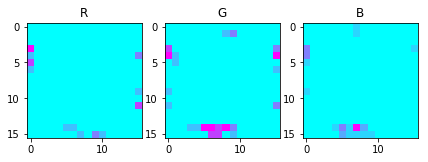

In [37]:
plot_random_forest_importances(RFC_estimators[0])

**Plot the feature importances** of your 'best' *RandomForestClassifier* instance. The patterns should be more complex.

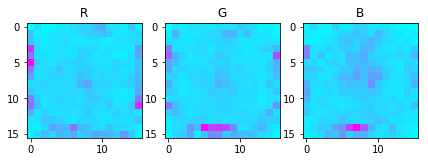

In [38]:
plot_random_forest_importances(best_RFC)

**Question.** Why do you think the features near the edge of the image so 'important'? Explain in 1-2 sentences.

<div style="border-bottom: 1px solid black;"></div>

### *Q5b &mdash;  Visualize the feature weights of LogisticRegression [5 marks]*

This question is essentially the same as **Q5a** except you will extract the per-class weights of a *LogisticRegression* estimator that was trained on emoji images.

**Implement *plot_logistic_weights*** so that for each of the 10 categories of emoji it plots three side-by-side images.  Use the *coef_* attribute of *LogisticRegression* to extract the $16 \times 16 \times 3$ weights for each category, and then generate a separate heatmap for each RGB channel. Since we want to see clearly which weights are positive or negative, use *cmap*='bwr' when plotting each heatmap. Use *suptitle* to label each group of heatmaps with its category label. Your function should generate $10 \times 3$ heatmaps total. Below are examples of 2 of the 10 possible rows:

<div style="margin-top:10px">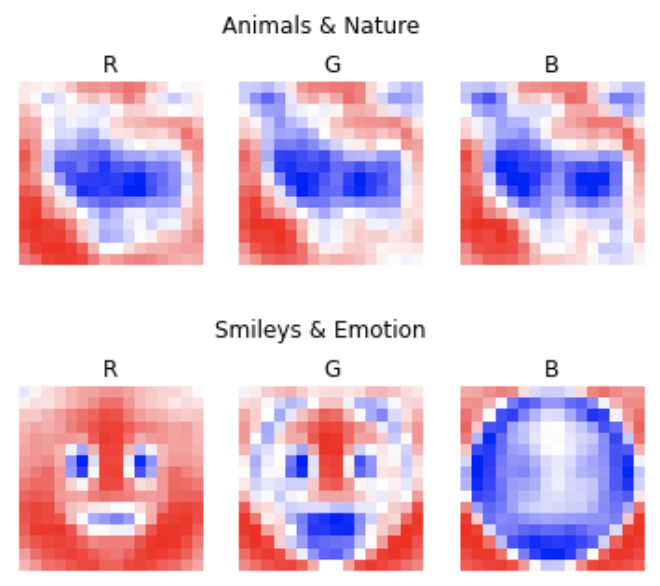</div>

*Hint:* Note that the $i^\text{th}$ set of weights may not match the order of categories. Use the *classes_* attribute of *LogisticRegression* to recover the category index.

In [39]:
def plot_logistic_weights(estimator):
    """
    Plots heatmaps showing the weights of the LogisticRegression estimator,
    with a separate plot for each class and for each colour channel.
    """
    # compute the coef feature of the estimator and reshape it to (10,16,16,3)
    # plot the coef feature for RGB separately
    for i in range(10):

        plt.figure(figsize=(6,5))
        plt.subplot(1,3,1)
        plt.imshow(estimator.coef_.reshape(10,16,16,3)[i,:,:,0],cmap='bwr')   # plot for R
        plt.title('R')

        
        plt.subplot(1,3,2)
        plt.imshow(estimator.coef_.reshape(10,16,16,3)[i,:,:,1],cmap='bwr')   # plot for G
        plt.title('G')


        plt.subplot(1,3,3)
        plt.imshow(estimator.coef_.reshape(10,16,16,3)[i,:,:,2],cmap='bwr')    # plot for B
        plt.title('B')
 

        plt.suptitle(emojis_categories[i],size=12, y=0.75)
        
        plt.show()
    
    assert isinstance(estimator, sklearn.linear_model.LogisticRegression)

**Check your code** by calling your function to plot the weights of the *LogisticRegression* classifier having *strongest* regularization (the one with *C*=1e-5).

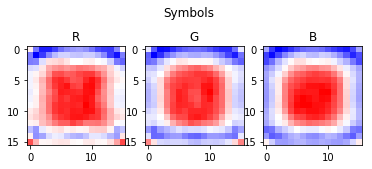

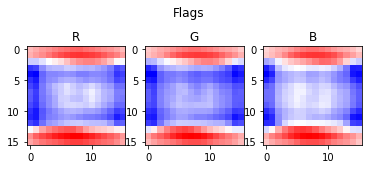

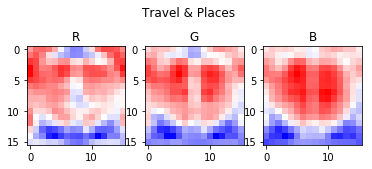

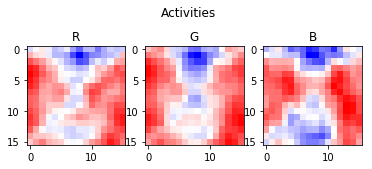

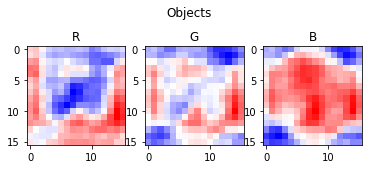

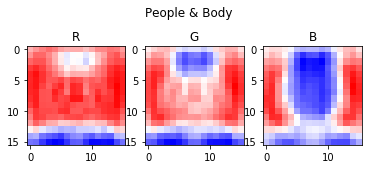

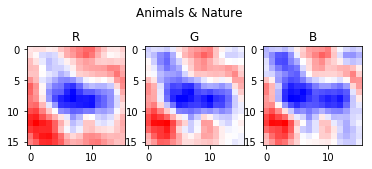

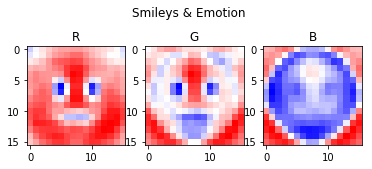

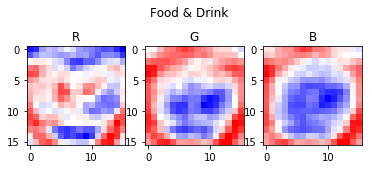

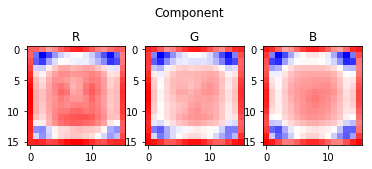

In [40]:
plot_logistic_weights(LRC_estimators[0])

**Plot the weights** of your 'best' *LogisticRegression* instance.

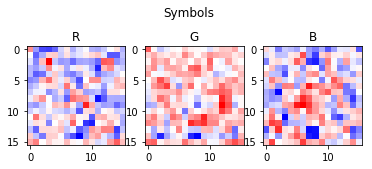

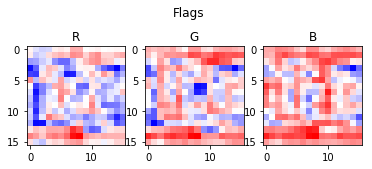

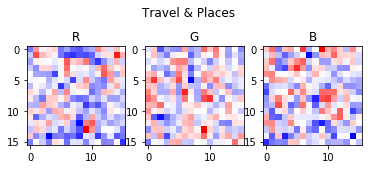

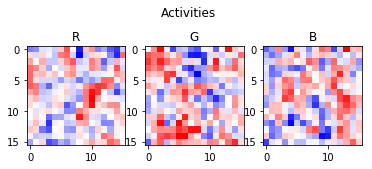

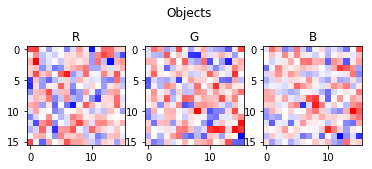

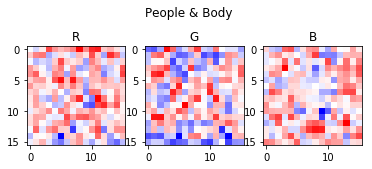

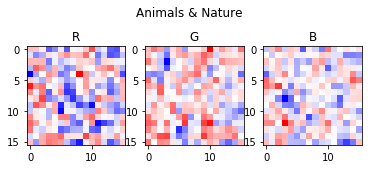

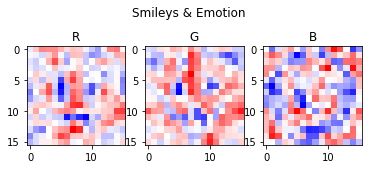

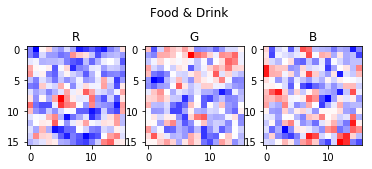

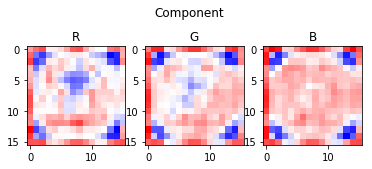

In [41]:
plot_logistic_weights(best_LRC)

**Question.** Was your best-performing *LogisiticRegression* classifier also the most interpretable? YES/NO then explain in 2-3 sentences.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q6 &mdash; Maximize the expected test-time performance of a DecisionTreeClassifier [10 marks]

In Q3, you plotted the effect of a lone hyperparameter on training, validation, and testing scores. But, you did not do a full hyperparameter search on any of the models.

In Q6, you should do a full hyperparameter search on a *DecisionTreeClassifier*, and demonstrate whether a full hyperparameter search can increase testing scores. Specifically, you will use *RandomizedSearchCV*.

First, **write a line of code** to split the full (unnormalized) emoji data set into 80% training and 20% testing. Your test set should be identical to Q2c but, unlike Q2c, do not normalize and do not further split the training data into a validation set. (You do not need to normalize the emoji pixels because decision tree is not affected by it anyway!)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Next, **write a few lines of code** to:
1. define a hyperparameter search space for a *DecisionTreeClassifier* and
2. find the best hyperparameters using *RandomizedSearchCV*.

Some specifics:
* Choose **at least four** *DecisionTreeClassifier* hyperparameters to search over, and choose a list of values for each.
* Configure *RandomizedSearchCV* to evaluate **at least 20** distinct hyperparameter settings (i.e., at least 20 samples from your search space).
* Configure *RandomizedSearchCV*'s to score each hyperparameter sample via **4-fold** cross validation. This matches the "60%/20%" training/validation ratio you manually did in Q3, but now *RandomizedSearchCV* does the split internally.



In [43]:
%%time

# 1: define the cross validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

# 2: define the range and distribution of each hyperparameter
uniform_distribution = scipy.stats.uniform(100, 2000)
max_depth_range = np.round(uniform_distribution.rvs(8))
max_features_range = ["auto", "sqrt", "log2"]
min_samples_split_range = np.array([1, 2, 3, 4, 5])
min_samples_leaf_range = np.array([1, 2, 3, 4, 5])
splitter_range = ["best", "random"]

# 3: define the grid parameters as dictionary 
param_grid = dict(max_depth=max_depth_range,min_samples_split=min_samples_split_range,
                  min_samples_leaf=min_samples_leaf_range, splitter = splitter_range)

# 4: define the grid 
grid = RandomizedSearchCV(sklearn.tree.DecisionTreeClassifier(random_state=0),param_grid, cv=cv);

# 5: training the grid
grid.fit(X_train, y_train);

Wall time: 46.1 s


**Print the best hyperparameters** that were found by your search, one hyperparameter per line.

In [44]:
# print hyperparameters of the best classifier
for k, v in grid.best_params_.items():
    print(str(k)+':', v)

splitter: best
min_samples_split: 2
min_samples_leaf: 4
max_depth: 975.0


Finally, **print the validation, training, and testing scores** 
```
cross-validation score of best hyperparameters:             0.???
training score of model trained using best hyperparameters: 0.???
testing score of model trained using best hyperparameters:  0.???
```
Your code cell should reproduce the above, but with the 3-digits numbers filled in. (Hint: You do not need to fit a new tree yourself to do this step.)

In [45]:
print("cross-validation score of best hyperparameters: ", '%0.3f' % grid.best_score_)
print("training score of model trained using best hyperparameters: ", '%0.3f' % grid.best_estimator_.score(X_train, y_train))
print("testing score of model trained using best hyperparameters: ", '%0.3f' % grid.best_estimator_.score(X_test, y_test))

cross-validation score of best hyperparameters:  0.561
training score of model trained using best hyperparameters:  0.867
testing score of model trained using best hyperparameters:  0.590


**Question.** Was the cross-validation score of your Q6 hyperparameter search better than the best validation score from your *DecisionTreeClassifier* search in Q3b? If so, what was the absolute percentage of improvement in accuracy? If not, why not?